In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import math
from imblearn.over_sampling import SMOTE

# Data Collection


In [46]:
# For Colab
#from google.colab import files
#file = files.upload()
#df = pd.read_csv("online_shoppers_intention.csv") 
#df.head()

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

No missing values found. A mix of categorical and numerical variables.

# Data Exploration

In [4]:
# Taking a look at the target variable
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [5]:
# summary statistics of all numerical variables
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [6]:
df.nunique()

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

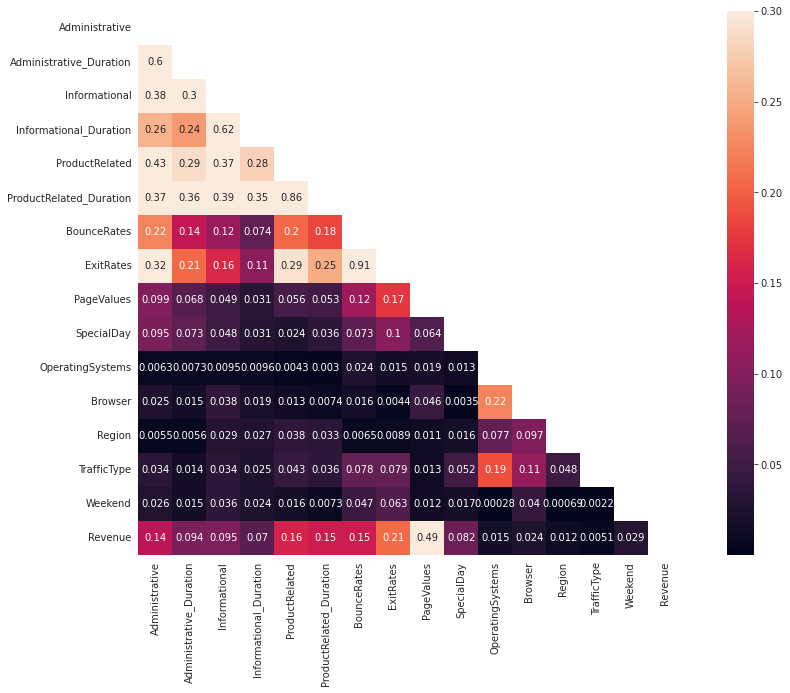

In [7]:
# Correlation between variables
corr = df.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot = True) # , annot=True

From the correlation map above, we can see that most of the variabels are not correlated. However, ExitRates and BounceRates are highly correlated (0.91 for coefficient)

In [8]:
df_X = df.drop("Revenue", axis = 1)

In [9]:
# Based on the dataset information, we have 7 categorical variables + 1 outcome and 10 numerical variables
cat_col = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Month','Weekend']

In [10]:
df[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   OperatingSystems  12330 non-null  int64 
 1   Browser           12330 non-null  int64 
 2   Region            12330 non-null  int64 
 3   TrafficType       12330 non-null  int64 
 4   VisitorType       12330 non-null  object
 5   Month             12330 non-null  object
 6   Weekend           12330 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 590.1+ KB


In [11]:
df_num = df_X.drop(labels = cat_col, axis =1)

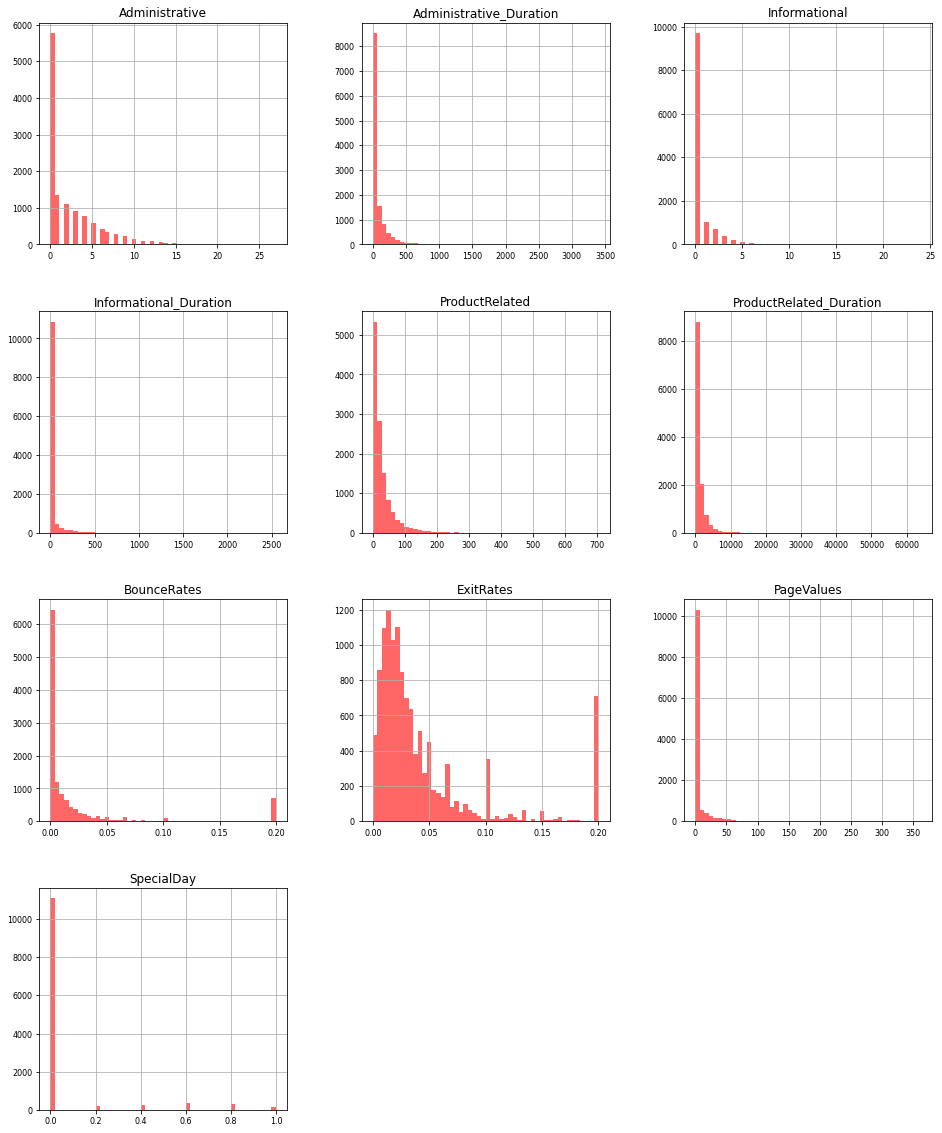

In [12]:
# Histogram for numerical variables 
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8,color="#FF6666");

We could see that from the histogram, most of our numerical variabels are highly skewed. Now, let's plot stacked bar chart to explore how each category is represented in different class.

<AxesSubplot:xlabel='Browser'>

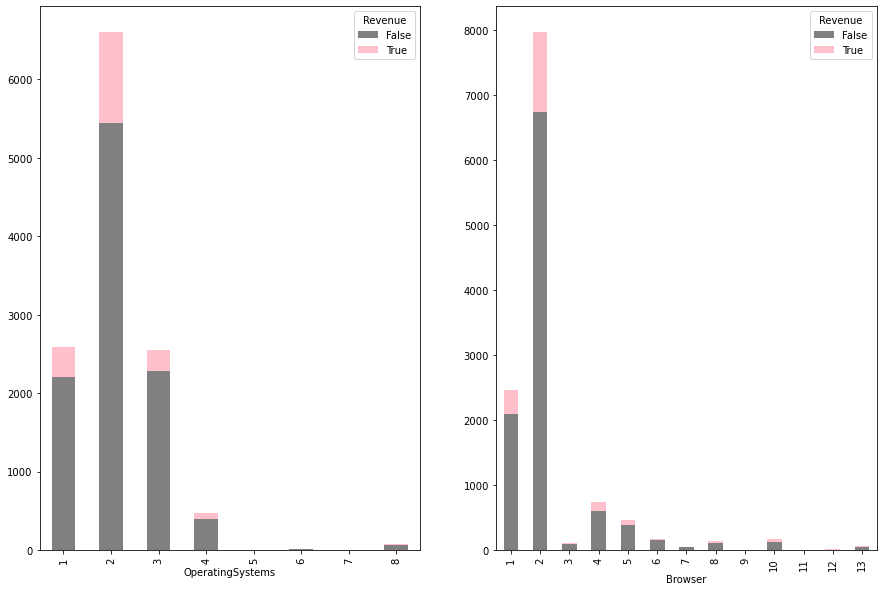

In [58]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax1= plt.subplot(121)
pd.crosstab(df['OperatingSystems'],df['Revenue']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(122)
pd.crosstab(df['Browser'],df['Revenue']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)

<AxesSubplot:xlabel='TrafficType'>

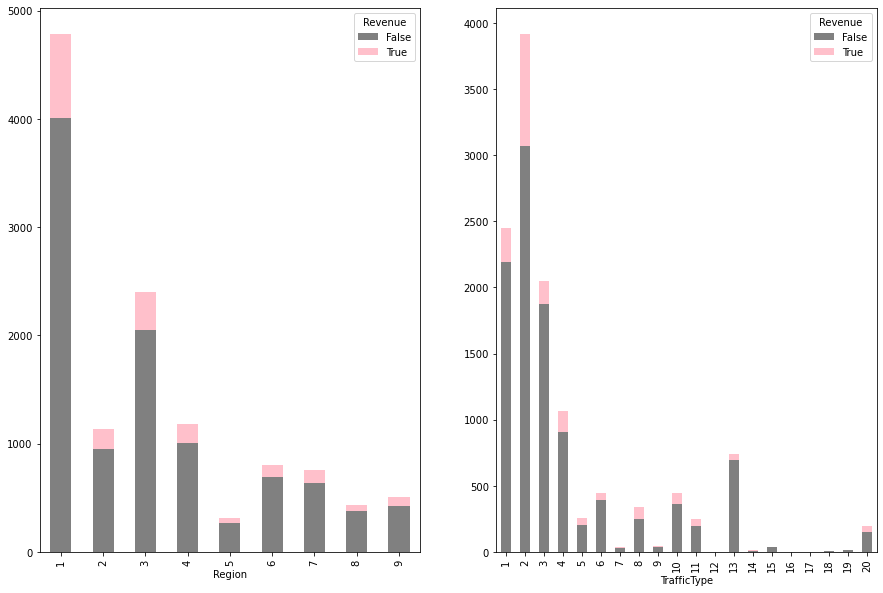

In [59]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax1= plt.subplot(121)
pd.crosstab(df['Region'],df['Revenue']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(122)
pd.crosstab(df['TrafficType'],df['Revenue']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)

<AxesSubplot:xlabel='Weekend'>

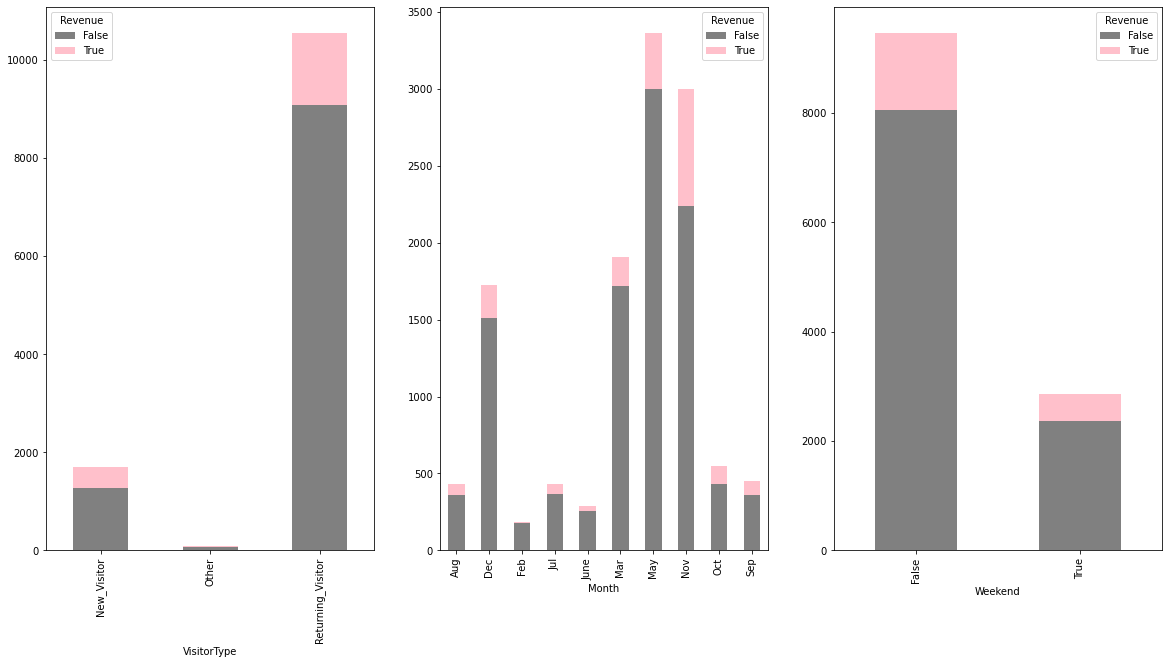

In [60]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax1= plt.subplot(131)
pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(132)
pd.crosstab(df['Month'],df['Revenue']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)
ax3= plt.subplot(133)
pd.crosstab(df['Weekend'],df['Revenue']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax3)

From the Stacked bar chart, we can see that there are some variables that have categories with very limited presense. Those variables are: traffic type, operating system and browser. We'll need to consider binning thoses categories to reduce dimension when we later convert all categorical data to dummy variables.

<AxesSubplot:>

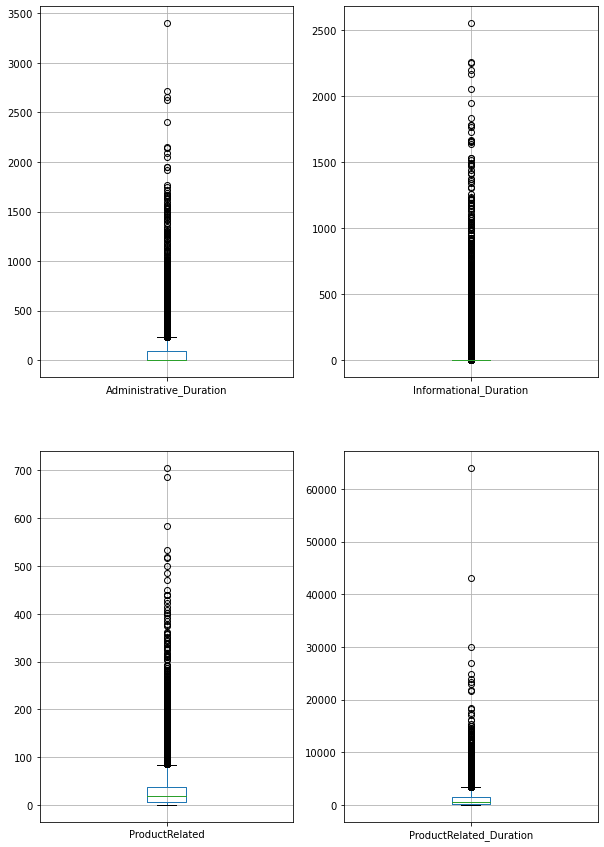

In [61]:
# Look at the boxplot for the numerical variables with very large std

fig, ax = plt.subplots(2,2,figsize=(10,15))
ax1= plt.subplot(221)
df.boxplot(column = ['Administrative_Duration'],ax=ax1)
ax2= plt.subplot(222)
df.boxplot(column = ['Informational_Duration'],ax=ax2)
ax3= plt.subplot(223)
df.boxplot(column = ['ProductRelated'],ax=ax3)
ax4= plt.subplot(224)
df.boxplot(column = ['ProductRelated_Duration'],ax=ax4)

# Data Preprocessing & Feature Engineering

In [13]:
# Convert TrafficType to categorical variable
df.TrafficType = df.TrafficType.astype('category')

In [14]:
# Create dummy variables for categorical variables
df = pd.get_dummies(df,columns=['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Month'])

In [15]:
# Convert boolean categorical variables to numeric variables
df.loc[:, ['Weekend', 'Revenue']] = df.loc[:, ['Weekend', 'Revenue']].astype('int')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 75 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  Weekend                        12330 non-null  int64  
 11  Revenue                        12330 non-null  int64  
 12  OperatingSystems_1             12330 non-null 

In [17]:
# Separate our predictors and response variable
X = df.drop('Revenue', axis= 1)
y = df['Revenue']

In [67]:
y

0        0
1        0
2        0
3        0
4        0
        ..
12325    0
12326    0
12327    0
12328    0
12329    0
Name: Revenue, Length: 12330, dtype: int64

### Binning rare categories
Some categories have very rare presense. To reduce dimension, bin some of those variables

In [18]:
# Bin low frequency OS categories
operOthers = X.loc[:,['OperatingSystems_4','OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7','OperatingSystems_8']]
X['operOthers'] = operOthers.any(axis=1).astype('int')
X.drop(['OperatingSystems_4','OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7','OperatingSystems_8'],axis=1,inplace=True)

In [19]:
# Bin low frequency Browser categories
otherBrowser = X.loc[:,['Browser_3','Browser_5', 'Browser_6', 'Browser_7', 'Browser_8',
       'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12', 'Browser_13']]
X['otherBrowser'] = otherBrowser.any(axis=1).astype('int')
X.drop(['Browser_3','Browser_5', 'Browser_6', 'Browser_7', 'Browser_8',
       'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12', 'Browser_13'],axis=1,inplace=True)

In [20]:
# Bin low frequency Region type
otherRegion = X.loc[:,['Region_5', 'Region_8', 'Region_9']]
X['otherRegion'] = otherRegion.any(axis=1).astype('int')
X.drop(['Region_5', 'Region_8', 'Region_9'],axis=1,inplace=True)

In [21]:
# Bin low frequency Traffic Type
otherTrafficType1 = X.loc[:,['TrafficType_7', 'TrafficType_9', 'TrafficType_12', 'TrafficType_14',
       'TrafficType_15', 'TrafficType_16', 'TrafficType_17', 'TrafficType_18',
       'TrafficType_19', 'TrafficType_20']]
X['otherTrafficType1'] = otherTrafficType1.any(axis=1).astype('int')
X.drop(['TrafficType_7', 'TrafficType_9', 'TrafficType_12', 'TrafficType_14',
       'TrafficType_15', 'TrafficType_16', 'TrafficType_17', 'TrafficType_18',
       'TrafficType_19', 'TrafficType_20'],axis=1,inplace=True)

In [22]:
# drop low frequency vistor Type
# First of all, the presence of this category is very low and it's very questionable whether it will affect the result
# Next, logically speaking, for visitor type, the other two types are "New" and "Returning", which pretty much
# encompass all the possible situations. Thus, it seems reasonable to drop this dummy variable
X.drop(['VisitorType_Other'],axis=1,inplace=True)

In [23]:
# Check other low presense categories' presense
X_cate = X.iloc[:,10:]
frequency = X_cate.sum()/len(X)
frequency[np.where(frequency < 0.05)[0]]

TrafficType_5        0.021087
TrafficType_6        0.036010
TrafficType_8        0.027818
TrafficType_10       0.036496
TrafficType_11       0.020032
Month_Aug            0.035118
Month_Feb            0.014923
Month_Jul            0.035036
Month_June           0.023358
Month_Oct            0.044526
Month_Sep            0.036334
operOthers           0.047770
otherTrafficType1    0.029440
dtype: float64

In [46]:
# Split and normalize the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1 ,test_size=0.3)

In [47]:
X_mean = X_train.iloc[:,:10].mean()
X_std = X_train.iloc[:,:10].std()

In [48]:
X_train.iloc[:,:10] = (X_train.iloc[:,:10]-X_mean)/X_std
X_test.iloc[:,:10] = (X_test.iloc[:,:10]-X_mean)/X_std

In [49]:
X_train_lr = X_train.drop(['ExitRates'],axis=1)
X_test_lr = X_test.drop(['ExitRates'],axis=1)

In [50]:
y_train_lr = y_train.copy()

In [51]:
# Oversample the training set using SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# For logistic regression
X_train_lr, y_train_lr = SMOTE().fit_resample(X_train_lr,y_train_lr)

In [52]:
def performance(y_test, pred):
    print('Recall is {}'.format(metrics.recall_score(y_test,pred)))
    print('Precision is {}'.format(metrics.precision_score(y_test,pred)))
    print('F-1 score is {}'.format(metrics.f1_score(y_test,pred)))
    print('Overall accuracy is {}'.format(metrics.accuracy_score(y_test,pred)))

# Model Fitting and Evaluation

## Logistic Regression

In [53]:
class LogisticRegression:
    
    def __init__(self,X,y, learningRate = 0.00001, tolerance = 0.00005, maxIteration = 5000):
        #super().__init__()
        self.X = X
        self.y =y
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.learningRate = learningRate
        
    def addX0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X])
    
    def sigmoid(self,z):
        sig = 1/(1+np.exp(-z))
        return sig
    
    def costFunction(self, X, y):
        pred_ =np.log(np.ones(X.shape[0])+np.exp(X.dot(self.w))) - X.dot(self.w)*y
        cost = pred_.sum( )
        return cost
    
    def gradient(self,X,y):
        sigmoid = self.sigmoid(X.dot(self.w))
        grad = (sigmoid -y ).dot(X)
        return grad
    
    def gradientDescent(self, X, y):
        errors = []
        last = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
        
            self.w = self.w - self.learningRate*self.gradient(X,y)
            curr = self.costFunction(X,y)
            
            diff = last - curr
            last - curr
            
            errors.append(curr)
            
            if diff < self.tolerance:
                print("The model stopped Learning")
                break
        # self.plot_cost(errors)
        
    def predict(self,X):
        pred = self.sigmoid(X.dot(self.w))
        return np.around(pred)
    
    def predictProb(self,X):
        pred = self.sigmoid(X.dot(self.w))
        return pred
        
    def evaluate(self, y, y_hat):
        
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        
        return recall, precision, accuracy
    
    def fit(self):
        self.w = np.ones(self.X.shape[1], dtype = np.float64)*0
        self.gradientDescent(self.X, self.y)
        
        print(self.w)
        
        y_hat_train = self.predict(self.X)
        recall, precision, accuracy = self.evaluate(self.y,y_hat_train)

        
        print("Accuracy is", accuracy)
        print('Recall is', recall)
        print('precision is ', precision)
        
        
    def plot(self):
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X[:, 0], self.X[:, 1], 
                     self.sigmoid(self.X.dot(self.w)), 
                     c = self.y[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    
    
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X[:, 0], self.X[:, 1], 
                   c=self.y[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X[:, 0], self.X[:, 1], 
                   c=self.y[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

In [58]:
lg_clf = LogisticRegression(X_train_lr,y_train_lr,learningRate = 1e-4, tolerance = 0.0001, maxIteration = 10000)
lg_clf.fit()

100%|███████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 236.06it/s]

Administrative                  -0.016118
Administrative_Duration         -0.014652
Informational                   -0.020788
Informational_Duration          -0.026981
ProductRelated                   0.048822
ProductRelated_Duration          0.145203
BounceRates                     -1.383770
PageValues                       2.242123
SpecialDay                      -0.105664
Weekend                         -0.148583
OperatingSystems_1               0.238829
OperatingSystems_2               0.442944
OperatingSystems_3               0.201436
Browser_1                        0.403037
Browser_2                        0.388317
Browser_4                       -0.003679
Region_1                        -2.128933
Region_2                        -2.375157
Region_3                        -2.191513
Region_4                        -2.462174
Region_6                        -2.338098
Region_7                        -2.559453
TrafficType_1                   -1.818833
TrafficType_2                   -1

In [59]:
pred = lg_clf.predict(X_test_lr)

In [60]:
pred_prob = lg_clf.predictProb(X_test_lr)
y_result = pd.DataFrame(pred_prob)

In [61]:
performance(y_test, pred)

Recall is 0.6218181818181818
Precision is 0.5968586387434555
F-1 score is 0.6090828138913624
Overall accuracy is 0.8813192754798594


<AxesSubplot:>

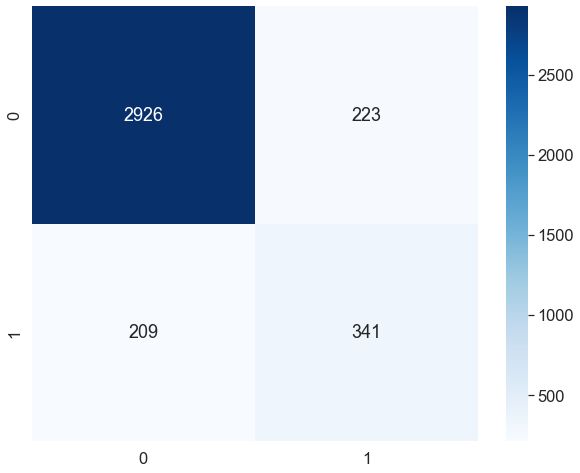

In [100]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred)
sns.set(font_scale=1.5)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

In [87]:
lg_clf.__dict__.get('w').sort_values()

Month_Feb                       -4.073982
TrafficType_13                  -3.125009
otherRegion                     -2.620050
TrafficType_6                   -2.618546
Region_7                        -2.617937
Month_June                      -2.440044
Region_4                        -2.395579
Region_2                        -2.376020
Region_6                        -2.288147
Region_3                        -2.222000
Month_Mar                       -2.168944
Month_Aug                       -2.159181
Month_Dec                       -2.111478
Region_1                        -2.110071
TrafficType_3                   -2.104375
TrafficType_10                  -2.055211
Month_May                       -1.979035
TrafficType_1                   -1.877867
Month_Jul                       -1.817799
Month_Oct                       -1.802113
TrafficType_5                   -1.693424
Month_Sep                       -1.661083
TrafficType_4                   -1.603337
TrafficType_11                  -1

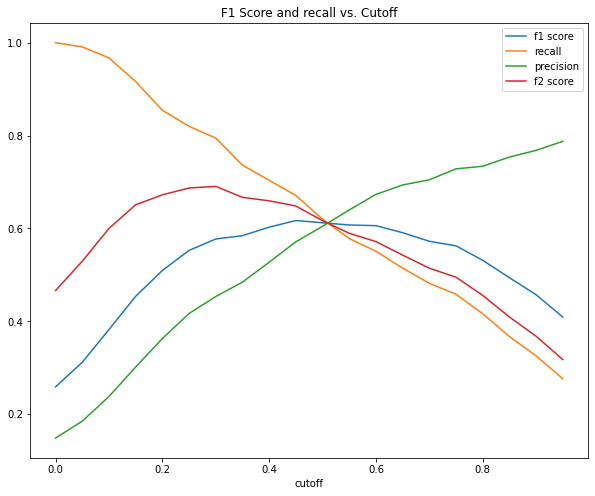

maximum f1 score  0.617056856187291 reached at cutoff of  0.45


In [88]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
plt.rcParams["figure.figsize"] = (10,8)
cutoffs = []
f1_scores = []
recalls = []
precisions = []
f2_scores = []
for i in range(20):
  cutoffs.append(i/20)
  y_pred = y_result[0].apply(lambda x: 1 if x > i/20 else 0)
  f1_scores.append(f1_score(y_test,y_pred))
  recalls.append(recall_score(y_test,y_pred))
  precisions.append(precision_score(y_test,y_pred))
  f2_scores.append(fbeta_score(y_test,y_pred,beta=2))
plt.plot(cutoffs, f1_scores, label = 'f1 score')
plt.plot(cutoffs, recalls, label = 'recall')
plt.plot(cutoffs, precisions, label = 'precision')
plt.plot(cutoffs, f2_scores, label = 'f2 score')
plt.xlabel('cutoff')
plt.title("F1 Score and recall vs. Cutoff")
plt.legend()
plt.show()
maxf1 = max(f1_scores)
print('maximum f1 score ', maxf1, 'reached at cutoff of ', cutoffs[f1_scores.index(maxf1)])

### Soft Magin SVM

In [25]:
from scipy import optimize
from scipy.optimize import Bounds

In [26]:
class MaxMarginClassifier:
    def __init__(self, C):
        self.C = C
    
    def fit(self, X, y):
        N = len(y)
        X = X.values
        y = y.values
        Xy = X*y[:, np.newaxis]
        Gramxy = np.matmul(Xy, Xy.T)   # y_i * y_j *(X_i.T * X_j)
        
        def ld0(G, alpha):
            return alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
        
        def deriviationLd0(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        alpha = np.ones(N)
        
        A = np.vstack((-np.eye(N), np.eye(N)))       
        bounds_alpha = Bounds(np.zeros(N), np.full(N, self.C))  

        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),
                        'jac': lambda a: y})
        
        optRes = optimize.minimize(fun = lambda a: -ld0(Gramxy, a),   # in computer, minimize is always faster than maximize
                                   x0 = alpha,
                                   jac = lambda a: - deriviationLd0(Gramxy, a),
                                   constraints=constraints,
                                   bounds = bounds_alpha)
        
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis =0)
        
        epsilons = 1e-6
        
        self.supportVectors = X[self.alpha > epsilons]
        
        self.supportlabels = y[self.alpha > epsilons]
        
        b = []
        
        for i in range(len(self.supportVectors)):
            b_i = self.supportlabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b.append(b_i)
            
        self.intercept = sum(b)/len(b)
        
        
        
    def predict(self, X):
        X = X.values
        return 2*(np.matmul(X, self.w)+ self.intercept >0) -1
            

In [136]:
class KernelSVM:
    def __init__(self, C=1, gamma=1):
        self.C = C
        self.gamma = gamma
        print('C is: {}, gamma is {}'.format(self.C,self.gamma))
    def rbf_kernel(self, X, Y, gamma):
        X_norm = np.sum(X ** 2, axis=-1)
        Y_norm = np.sum(Y ** 2, axis=-1)
        K = np.exp(-gamma * (X_norm[:, None] + Y_norm[None, :] - 2 * np.dot(X, Y.T)))
        return K
    
    
    def fit(self, X, y):
        N = len(y)
        X = X.values
        y = y.values
        self.gamma = 2*self.gamma/len(X[0])
        yy = y[:, np.newaxis].dot(y[:, np.newaxis].T)
        Gramxy = yy*self.rbf_kernel(X,X,self.gamma)   # y_i * y_j *(X_i.T * X_j)
        print('Gramxy calculated')
        def ld0(G, alpha):
            return alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
        
        def deriviationLd0(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        alpha = np.ones(N)
        
        A = np.vstack((-np.eye(N), np.eye(N)))       
        bounds_alpha = Bounds(np.zeros(N), np.full(N, self.C))  

        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),
                        'jac': lambda a: y})
        print('Begin optimization')
        optRes = optimize.minimize(fun = lambda a: -ld0(Gramxy, a),   # in computer, minimize is always faster than maximize
                                   x0 = alpha,
                                   tol = 1e-6,
                                   method='SLSQP',
                                   jac = lambda a: - deriviationLd0(Gramxy, a),
                                   constraints=constraints,
                                   bounds = bounds_alpha,
                                   options={'iprint':1, 'disp':True} )
        print('Optimization finished')
        self.result = optRes
        self.alpha = optRes.x
        #self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis =0)
        
        epsilons = 1e-6
        
        self.supportVectors = X[self.alpha > epsilons]
        self.supportAlpha = self.alpha[self.alpha > epsilons]
        self.supportlabels = y[self.alpha > epsilons]
        print('Support Vectors found')
        b = []
        
        for i in range(len(self.supportVectors)):
            #b_i = self.supportlabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b_i = self.supportlabels[i] - (self.supportAlpha*self.supportlabels*self.rbf_kernel(self.supportVectors[i:i+1],self.supportVectors ,self.gamma)[0]).sum()           
            b.append(b_i)
            
        self.intercept = sum(b)/len(b)
        print('Intercept calculated')
        return self
        
    def predict(self, X):
        X = X.values
        alphaY = self.supportAlpha*self.supportlabels
        return 2*((alphaY[:,np.newaxis]*(self.rbf_kernel(self.supportVectors ,X ,self.gamma))).sum(axis = 0)+ self.intercept >0) -1
    
    def sigmoid(self,z):
        sig = 1/(1+np.exp(-z))
        return sig
    
    def predictProb(self, X):
        X = X.values
        alphaY = self.supportAlpha*self.supportlabels
        return self.sigmoid((alphaY[:,np.newaxis]*(self.rbf_kernel(self.supportVectors ,X ,self.gamma))).sum(axis = 0)+ self.intercept) 

    def score(self,X,y):
        return metrics.f1_score(self.predict(X),y)
    
    def get_params(self, deep=False):

        params = {'C': self.C,
                  'gamma': self.gamma
                  }

        return params

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Normalization

In [125]:
y_svm = y.copy()
y_svm.replace(0,-1,inplace= True)
X_train, X_test, y_train, y_test = train_test_split(X, y_svm, random_state= 1 ,test_size=0.85)
X_mean = X_train.iloc[:,:10].mean()
X_std = X_train.iloc[:,:10].std()
X_train.iloc[:,:10] = (X_train.iloc[:,:10]-X_mean)/X_std
X_test.iloc[:,:10] = (X_test.iloc[:,:10]-X_mean)/X_std

### PCA

In [113]:
class PCA_eigen:
    def __init__(self, X):
        self.corr = X.corr()
        self.corr.fillna(0,inplace=True)
        self.egnvalues,self.egnvectors=np.linalg.eigh(self.corr)
        self.egnvalues=abs(np.sort(-self.egnvalues))
        # The column egnvectors[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i]. 
        variance_ratio=self.egnvalues/self.egnvalues.sum()
        self.cumvar = np.cumsum(variance_ratio)
    def transform(self,X,explain_var):
        PCs = np.where(self.cumvar>explain_var)[0].min()
        print('Return {} PCs and explain {}% variance'.format(PCs,self.cumvar[PCs]*100 ))
        return X.dot(self.egnvectors[:,:PCs])

In [114]:
#corr = X_train.corr()
##corr.fillna(0,inplace=True)
#egnvalues,egnvectors = np.linalg.eigh(corr.values)
#egnvalues=abs(np.sort(-egnvalues))
#variance_ratio=egnvalues/egnvalues.sum()

In [31]:
#corr = X_train.corr()
#corr.fillna(0,inplace=True)
#u,s,v = np.linalg.svd(corr)
#egnvalues, egnvectors = s, u

In [117]:
explained_variance = pd.DataFrame({'Cum_Variance':np.cumsum(variance_ratio)}, 
                                  index = ['PC{}'.format(i+1) for i in range(len(variance_ratio))])

In [118]:
explained_variance[explained_variance['Cum_Variance'] < 0.96]

,Cum_Variance
PC1,0.073086
PC2,0.133445
PC3,0.185402
PC4,0.225430
PC5,0.264389
PC6,0.296589
PC7,0.326969
PC8,0.356969
PC9,0.385463
PC10,0.413008


In [126]:
PCA_clf = PCA_eigen(X_train)
X_train = PCA_clf.transform(X_train,0.97)
X_test = PCA_clf.transform(X_test,0.97)

Return 37 PCs and explain 97.62838290662306% variance
Return 37 PCs and explain 97.62838290662306% variance


In [137]:
X_train.shape

(3090, 37)

### SMOTE

In [128]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train) 

In [129]:
X_train.shape

(3090, 37)

### Grid Search SVM

In [40]:
from sklearn.model_selection import GridSearchCV


In [53]:
parameters = {'C': np.linspace(0.5, 2, 4),
              'gamma': np.linspace(0.5, 0.6, 10)}
clf = KernelSVM()       
gs = GridSearchCV(clf, parameters, cv=2)

C is: 1, gamma is 1


In [54]:
gs.fit(X_train, y_train)

C is: 1, gamma is 1
C is: 1, gamma is 1
Gramxy calculated
Begin optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -94.98361062868204
            Iterations: 33
            Function evaluations: 35
            Gradient evaluations: 33
Optimization finished
Support Vectors found
Intercept calculated
C is: 1, gamma is 1
Gramxy calculated
Begin optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -81.58063901573895
            Iterations: 35
            Function evaluations: 36
            Gradient evaluations: 35
Optimization finished
Support Vectors found
Intercept calculated
C is: 1, gamma is 1
Gramxy calculated
Begin optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -94.76447371475882
            Iterations: 33
            Function evaluations: 35
            Gradient evaluations: 33
Optimization finished
Support Vectors found
Inter

GridSearchCV(cv=2, estimator=<__main__.KernelSVM object at 0x000001F453D5A650>,
             param_grid={'gamma': array([0.5       , 0.51111111, 0.52222222, 0.53333333, 0.54444444,
       0.55555556, 0.56666667, 0.57777778, 0.58888889, 0.6       ])})

In [55]:
gs.best_params_

{'gamma': 0.5333333333333333}

In [44]:
pred = gs.best_estimator_.predict(X_test)
performance(y_test,pred)
pd.crosstab(pred,y_test)

Recall is 0.5091412742382272
Precision is 0.6999238385376999
F-1 score is 0.5894804361770366
Overall accuracy is 0.8907290421717603


Revenue,-1,1
row_0,,
-1,9515,886
1,394,919


### Run RBF Kernel SVM

We run soft margin SVM with RBF kernel, altough we use few (10%) data for fitting the model, it's performance is great.

After we binned those dummy features with low information, we inspected the continuous features and noticed there are significant correlation between some of them. Hence, we run PCA to process our data for better performance. The reasons we do so are :  
<b>1)</b> The PCA solve the high correlation by project our data into perpendicular axes, it will reduce the number of predictors.   
<b>2)</b> PCA will filter noise by dropping the last few PCs which contain most of noise that extracted by PCA, in this way, our model could be better.   
<b>3)</b> Since we apply RBF kernel here, we can't directly obtain a linear function(w cannot be calculated), so it's hard to interpret the model. With this consideration, using PCA would not exert extra problem of losing explanation ability.   

The RBF has the form of   
$$k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2\sigma^2} \right)$$
In SVM, we use gamma instead of $\sigma$, the relationship of $\gamma$ and $\sigma$ is:   
$$ \frac{2\gamma}{n_{feature}} = \frac{1}{2\sigma^2}$$    
where n_feature is # of features we used in fitting.   
The benefit of RBF kernel is it will solve the non-linearity by project the data in high dimension.


Then, we import grid search package here which is simple cross-validation method to help us find best hyper-parameters in user defined parameters grid. Here, we have 2 hyper-parameters, which are C (penalty) and gamma (kernel parameter). Their impact ot our model can be discribed as:
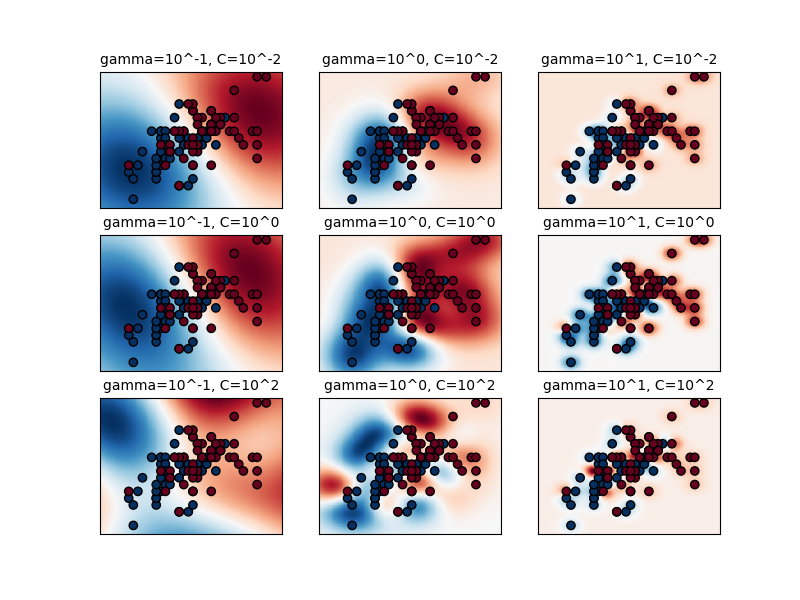   
[1] https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

After several grid Search Cross-Validation, we find the best param as C = 1, gamma = 0.53, where we have the performance as:


In [139]:
svm_clf = KernelSVM(C =1, gamma= 0.53)
svm_clf = svm_clf.fit(X_train, y_train)

C is: 1, gamma is 0.53
Gramxy calculated
Begin optimization
Iteration limit reached    (Exit mode 9)
            Current function value: -1372.4704952214547
            Iterations: 100
            Function evaluations: 112
            Gradient evaluations: 100
Optimization finished
Support Vectors found
Intercept calculated


The best model as followed:

In [141]:
#after smote
pred = svm_clf.predict(X_test)
performance(y_test,pred)# training 15, with smote
pd.crosstab(pred,y_test, rownames= ['Prediction']) # C =1, gamma= 0.53, data 15%, PCA 97% var
# do this for probability

Recall is 0.7256857855361596
Precision is 0.5467355565993424
F-1 score is 0.6236271095633538
Overall accuracy is 0.8659479057341857


Revenue,-1,1
Prediction,,
-1,7912,440
1,965,1164


In [60]:
# without smote
pred = svm_clf.predict(X_test)
performance(y_test,pred)# training 15%, without smote
pd.crosstab(pred,y_test) # C =1, gamma= 0.53, data 5%, PCA 36

Recall is 0.5426666666666666
Precision is 0.6945392491467577
F-1 score is 0.6092814371257484
Overall accuracy is 0.8941605839416058


Revenue,-1,1
row_0,,
-1,8006,686
1,358,814


In [144]:
y_result = svm_clf.predictProb(X_test)

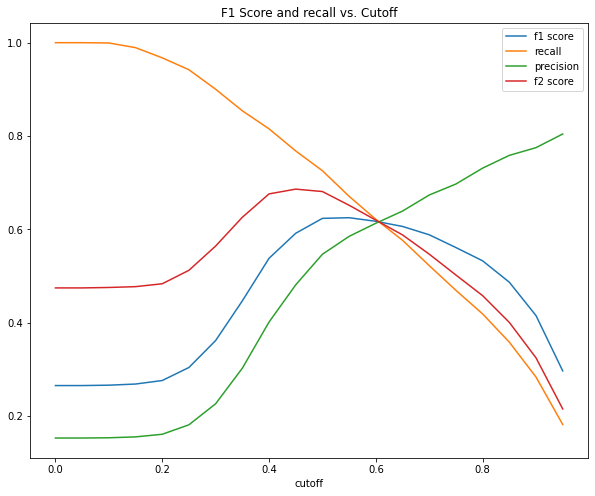

maximum f1 score  0.6250363055474877 reached at cutoff of  0.55
maximum f2 score  0.6862745098039216 reached at cutoff of  0.45


In [160]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
cutoffs = []
f1_scores = []
recalls = []
precisions = []
f2_scores = []
for i in range(20):
    cutoffs.append(i/20)
    y_pred = ((y_result> i/20).astype(int)*2-1)
    f1_scores.append(f1_score(y_test,y_pred))
    recalls.append(recall_score(y_test,y_pred))
    precisions.append(precision_score(y_test,y_pred))
    f2_scores.append(fbeta_score(y_test,y_pred,beta=2))
plt.plot(cutoffs, f1_scores, label = 'f1 score')
plt.plot(cutoffs, recalls, label = 'recall')
plt.plot(cutoffs, precisions, label = 'precision')
plt.plot(cutoffs, f2_scores, label = 'f2 score')
plt.xlabel('cutoff')
plt.title("F1 Score and recall vs. Cutoff")
plt.legend()
plt.show()
maxf1 = max(f1_scores)
maxf2 = max(f2_scores)
print('maximum f1 score ', maxf1, 'reached at cutoff of ', cutoffs[f1_scores.index(maxf1)])
print('maximum f2 score ', maxf2, 'reached at cutoff of ', cutoffs[f2_scores.index(maxf2)])

## KNN

In [12]:
import math
from scipy.spatial import distance
from sklearn import preprocessing
from collections import Counter
from math import sqrt


In [14]:
#Dataset Spliting

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [15]:
#Normalization

#Fitting Scaler
X_train_num = X_train.iloc[:,0:8]
scaler = preprocessing.StandardScaler().fit(X_train_num)
X_train_num = pd.DataFrame(scaler.transform(X_train_num),index=X_train.index)
X_train.iloc[:,0:8] = X_train_num.iloc[:,0:8]


#Normalizing X_test
X_test_num = X_test.iloc[:,0:8]
X_test_num = pd.DataFrame(scaler.transform(X_test_num),index=X_test.index)
X_test.iloc[:,0:8] = X_test_num.iloc[:,0:8]

In [16]:
#Transfer to numpy

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [21]:
class KNNClassifier():

    def __init__(self, k):
        assert k >= 1
        self.k = k
        self._X_train = None 
        self._y_train = None
        
    def fit(self, X_train, y_train):
        self._X_train = X_train
        self._y_train = y_train
        return self
    
    def predict(self, X_predict):
        return np.array([self._predict(x) for x in X_predict])

    def _predict(self, x_single):
        distances = [sqrt(np.sum((x_train - x_single) ** 2)) for x_train in self._X_train]
        nearst = np.argsort(distances)
        topK_y = [self._y_train[i] for i in nearst[:self.k]]
        
        #Transfering
        neighbours = []
        for i in topK_y:
            neighbours.append(i.tolist()[0])
            
        #Majority Voting
        votes = Counter(neighbours)
        predict_y = votes.most_common(1)[0][0]
        neighbours = []
        return predict_y
    
    def __repr__(self):
        return "KNNClassifier()"

In [22]:
#Grid Search

from sklearn.metrics import zero_one_loss


train_mcr = []
test_mcr = []

kmax = 51

for i in range(1, kmax+1,5):
    neigh = KNNClassifier(k = i)
    neigh.fit(X_train,y_train)
    y_pred_train = neigh.predict(X_train)
    y_pred_test = neigh.predict(X_test)

    y_train_list = []
    for i in y_train:
        y_train_list.append(i[0])


    y_test_list = []
    for i in y_test:
        y_test_list.append(i[0])
    

    train_mcr.append(zero_one_loss(y_train, y_pred_train))
    test_mcr.append(zero_one_loss(y_test, y_pred_test))

    print('Finish k=',i)

Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]
Finish k= [0]


In [23]:
train_mcr

[0.0,
 0.06337620206233341,
 0.09581740238674541,
 0.08654848800834203,
 0.09790290812188618,
 0.09164639091646387,
 0.09848221527053647,
 0.09373189665160464,
 0.09929324527864669,
 0.09662843239485575,
 0.1021897810218978]

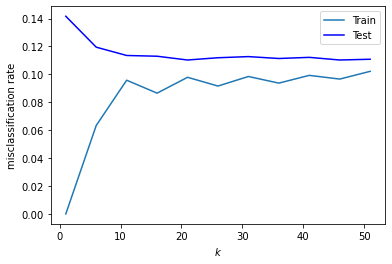

In [39]:


xi = np.arange(1,52,5)
plt.figure()
plt.plot(xi,train_mcr,xi,test_mcr, 'b')
plt.legend(['Train','Test'])
plt.xlabel('$k$')
plt.ylabel('misclassification rate')
plt.show()

In [38]:
np.arange(1,52,5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51])

In [26]:
train_mcr

[0.0,
 0.06337620206233341,
 0.09581740238674541,
 0.08654848800834203,
 0.09790290812188618,
 0.09164639091646387,
 0.09848221527053647,
 0.09373189665160464,
 0.09929324527864669,
 0.09662843239485575,
 0.1021897810218978]

In [27]:
test_mcr

[0.14165990808326578,
 0.11949175452825089,
 0.11354420113544206,
 0.11300351446336843,
 0.11030008110300082,
 0.11192214111922139,
 0.11273317112733172,
 0.11138145444714787,
 0.1121924844552582,
 0.11030008110300082,
 0.11084076777507434]

In [40]:


from sklearn import metrics

knn = KNNClassifier(k= 50 )
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)



In [43]:

print('Accuracy:',metrics.accuracy_score(y_pred,y_test))
print('F1 Score:',metrics.f1_score(y_pred,y_test))
print('Recall:',metrics.recall_score(y_pred,y_test))

Accuracy: 0.8888888888888888
F1 Score: 0.6155285313376988
Recall: 0.6339113680154143


In [44]:
#KNN， k=10


knn_10 = KNNClassifier(k=10)
knn_10.fit(X_train,y_train)
y_pred_10 = knn.predict(X_test)




In [46]:
print('Accuracy:',metrics.accuracy_score(y_pred_10,y_test))
print('F1 Score:',metrics.f1_score(y_pred_10,y_test))
print('Recall:',metrics.recall_score(y_pred_10,y_test))

Accuracy: 0.8888888888888888
F1 Score: 0.6155285313376988
Recall: 0.6339113680154143


### Neural Net

In [275]:
# import necessary dependencies

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import os
import warnings
from tensorflow.keras import layers
from keras_tuner.tuners import Hyperband
from sklearn.model_selection import train_test_split
from datetime import datetime
from packaging import version
from sklearn import metrics
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [278]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [302]:
y_train = y_train.values
y_test = y_test.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

#### Base model for nn

In [279]:
model = Sequential()
model.add(Dense(units = 64,
                kernel_initializer='normal',
                activation='sigmoid',
                input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=32,
                kernel_initializer='normal',
                activation='relu'))
model.add(Dense(units=2,
                kernel_initializer='normal',
                activation='softmax'))
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


history = model.fit(X_train,
                    y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data = (X_test,y_test))



model.summary()

Train on 9864 samples, validate on 2466 samples
Epoch 1/20
9864/9864 [==============================] - 2s 192us/step - loss: 0.4510 - accuracy: 0.8376 - val_loss: 0.4386 - val_accuracy: 0.8333
Epoch 2/20
9864/9864 [==============================] - 2s 180us/step - loss: 0.4097 - accuracy: 0.8482 - val_loss: 0.4308 - val_accuracy: 0.8333
Epoch 3/20
9864/9864 [==============================] - 1s 141us/step - loss: 0.3994 - accuracy: 0.8482 - val_loss: 0.4112 - val_accuracy: 0.8333
Epoch 4/20
9864/9864 [==============================] - 1s 129us/step - loss: 0.3881 - accuracy: 0.8482 - val_loss: 0.3973 - val_accuracy: 0.8333
Epoch 5/20
9864/9864 [==============================] - 1s 129us/step - loss: 0.3785 - accuracy: 0.8482 - val_loss: 0.3873 - val_accuracy: 0.8333
Epoch 6/20
9864/9864 [==============================] - 1s 133us/step - loss: 0.3729 - accuracy: 0.8481 - val_loss: 0.3819 - val_accuracy: 0.8341
Epoch 7/20
9864/9864 [==============================] - 1s 141us/step - loss

In [280]:
y_result = pd.DataFrame(model.predict(X_test))
y_pred = y_result[0].apply(lambda x: 1 if x < 0.5 else 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      2055
           1       0.73      0.32      0.45       411

    accuracy                           0.87      2466
   macro avg       0.80      0.65      0.69      2466
weighted avg       0.85      0.87      0.85      2466



#### Model tuning

In [281]:
def build_model(hp): # hyperparameter
  print('build_model function called')
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 2, 25)): # number of hidden layers 
      # number of nodes in every hidden nodes
      model.add(layers.Dense(units = hp.Int('units' + str(i), min_value=32, max_value=512, step=32),
                              kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']),
                              activation= hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(2, kernel_initializer= hp.Choice('initializer', ['uniform', 'normal']), activation='softmax'))

  model.compile(
      optimizer = 'adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
  return model

In [298]:
hyperband_tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='project_tuner',
    project_name='shopping_intention_hyperband',
    overwrite = False
)

build_model function called


In [299]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_lose',patience=5)

In [301]:
hyperband_tuner.search(
    X_train,
    y_train,
    epochs = 10,
    validation_data = (X_test, y_test),
    callbacks = [stop_early]
)

best_hps = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 01m 09s]
val_accuracy: 0.886455774307251

Best val_accuracy So Far: 0.8884833455085754
Total elapsed time: 00h 31m 13s
INFO:tensorflow:Oracle triggered exit


In [305]:
model = hyperband_tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_test,y_test))
model.summary()

build_model function called
Train on 9864 samples, validate on 2466 samples
Epoch 1/30
9864/9864 [==============================] - 6s 565us/sample - loss: 0.3884 - accuracy: 0.8468 - val_loss: 0.3426 - val_accuracy: 0.8333
Epoch 2/30
9864/9864 [==============================] - 6s 599us/sample - loss: 0.3143 - accuracy: 0.8730 - val_loss: 0.3120 - val_accuracy: 0.8719
Epoch 3/30
9864/9864 [==============================] - 5s 534us/sample - loss: 0.2849 - accuracy: 0.8902 - val_loss: 0.3040 - val_accuracy: 0.8816
Epoch 4/30
9864/9864 [==============================] - 6s 612us/sample - loss: 0.2649 - accuracy: 0.8958 - val_loss: 0.2736 - val_accuracy: 0.8873
Epoch 5/30
9864/9864 [==============================] - 5s 465us/sample - loss: 0.2563 - accuracy: 0.8978 - val_loss: 0.2787 - val_accuracy: 0.8796
Epoch 6/30
9864/9864 [==============================] - 4s 452us/sample - loss: 0.2461 - accuracy: 0.9008 - val_loss: 0.2754 - val_accuracy: 0.8856
Epoch 7/30
9864/9864 [==============

In [311]:
%%capture
eval_result = model.evaluate(X_test, y_test)

In [312]:
print('[test loss, test acc]: ',eval_result)

[test loss, test acc]:  [0.5456015513567836, 0.8751014]


In [313]:
y_result = model.predict(X_test)
y_result = pd.DataFrame(y_result)
y_pred = y_result[0].apply(lambda x: 1 if x < 0.5 else 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2055
           1       0.67      0.49      0.57       411

    accuracy                           0.88      2466
   macro avg       0.79      0.72      0.75      2466
weighted avg       0.86      0.88      0.87      2466



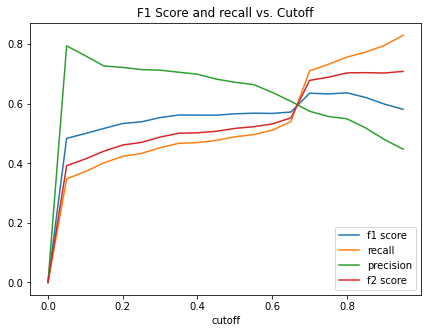

maximum f1 score  0.6366427840327533 reached at cutoff of  0.8


In [314]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
cutoffs = []
f1_scores = []
recalls = []
precisions = []
f2_scores = []
for i in range(20):
  cutoffs.append(i/20)
  y_pred = y_result[0].apply(lambda x: 1 if x < i/20 else 0)
  f1_scores.append(f1_score(y_test,y_pred))
  recalls.append(recall_score(y_test,y_pred))
  precisions.append(precision_score(y_test,y_pred))
  f2_scores.append(fbeta_score(y_test,y_pred,beta=2))
plt.plot(cutoffs, f1_scores, label = 'f1 score')
plt.plot(cutoffs, recalls, label = 'recall')
plt.plot(cutoffs, precisions, label = 'precision')
plt.plot(cutoffs, f2_scores, label = 'f2 score')
plt.xlabel('cutoff')
plt.title("F1 Score and recall vs. Cutoff")
plt.legend()
plt.show()
maxf1 = max(f1_scores)
maxf2 = max(f2_scores)
print('maximum f1 score ', maxf1, 'reached at cutoff of ', cutoffs[f1_scores.index(maxf1)])